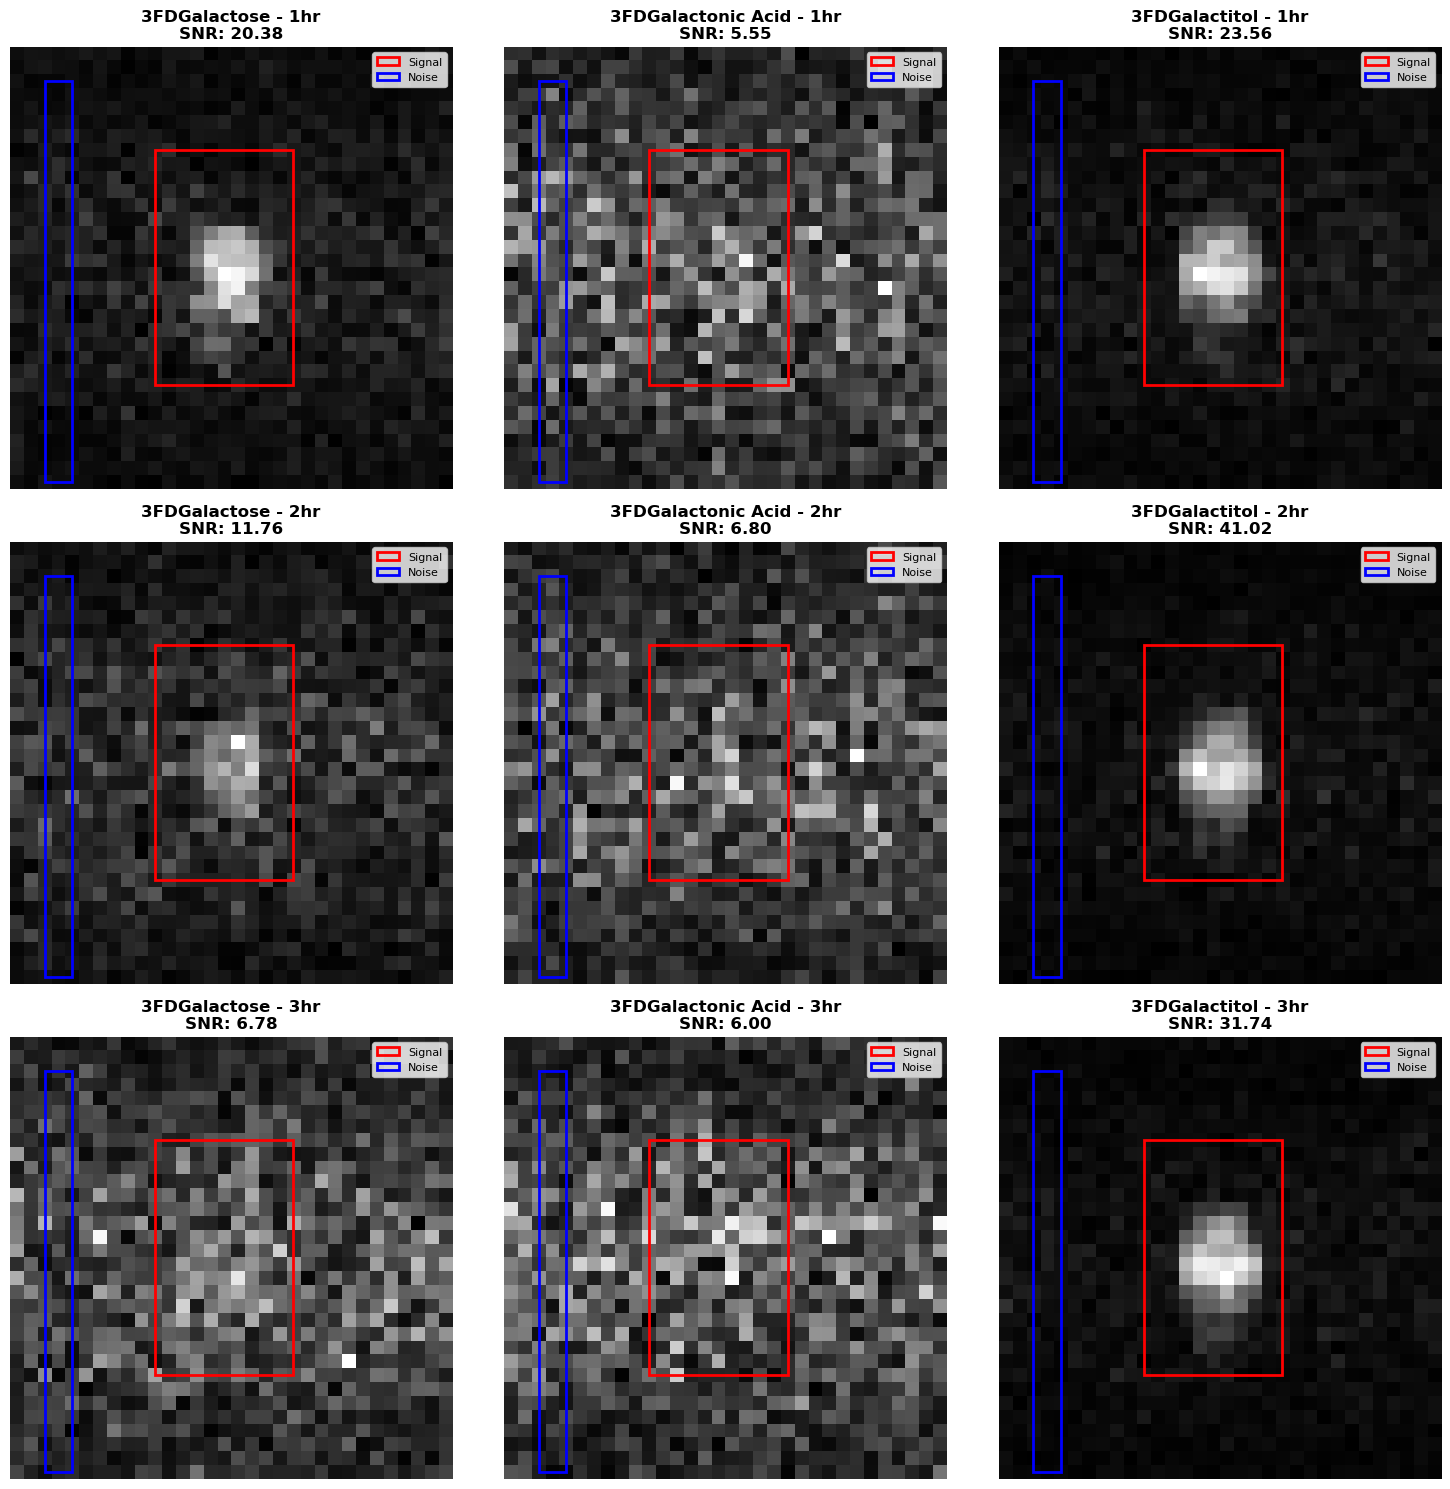

✅ **SNR visualization saved:** C:\Users\libis\Desktop\FMRI-Metabolism-Quantification-main\output_images\snr_results_p2.png


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.patches as patches

def compute_snr(image):
    """
    Computes the Signal-to-Noise Ratio (SNR) for a given MRI image.

    📌 Method:
    - The **signal region** is pre-defined based on expected fluorinated sugar activity.
    - The **noise region** is selected from a stable, non-activated background.

    🔍 This ensures **consistent** and **meaningful** comparisons across scans.
    """
    signal_region = image[7:24, 10:20]  # Adjusted for experiment setup
    noise_region = image[2:31, 2:4]  # Baseline noise reference

    noise = np.std(noise_region)
    max_signal = np.max(signal_region)
    snr = max_signal / noise if noise > 0 else 0

    return snr, max_signal, noise, noise_region  

def highlight_snr_regions_and_display_snr(images, probe, output_dir):
    """
    🎨 **Visualizes & Computes SNR for MRI images.**
    - Annotates signal/noise regions.
    - Displays each image with calculated SNR.
    - Saves a **combined image** with all results.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    num_images = len(images)
    cols = min(3, num_images)
    rows = (num_images // cols) + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = np.array(axes).reshape(-1)

    for ax, (file_name, img) in zip(axes, images.items()):
        img_array = np.array(img)
        snr, max_signal, noise, _ = compute_snr(img_array)

        # 🏷 **Title with Time & Metabolite Information**
        formatted_title = format_title(file_name, probe)

        ax.imshow(img_array, cmap="gray")
        ax.set_title(f"{formatted_title}\nSNR: {snr:.2f}", fontsize=12, fontweight='bold')
        ax.axis("off")

        # 📌 **Add signal & noise markers**
        signal_rect = patches.Rectangle((10, 7), 10, 17, linewidth=2, edgecolor='r', facecolor='none', label="Signal")
        ax.add_patch(signal_rect)

        noise_rect = patches.Rectangle((2, 2), 2, 29, linewidth=2, edgecolor='b', facecolor='none', label="Noise")
        ax.add_patch(noise_rect)

        ax.legend(loc="upper right", fontsize=8)

    # Hide any unused subplots
    for ax in axes[len(images):]:
        ax.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"snr_results_{probe}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"✅ **SNR visualization saved:** {save_path}")

def format_title(file_name, probe):
    """
    Formats the filename into a readable title based on probe type.

    🏷 Converts filenames into **clear labels** including:
    - **Metabolite type**
    - **Time after injection**
    """
    parts = file_name.replace(".tif", "").split("_")
    if len(parts) < 4:
        return file_name  # Return original if unexpected format

    time_map = {"t1": "1hr", "t2": "2hr", "t3": "3hr"}
    metabolite_map = {
        "p1": {"m1": "3FDGlucose", "m3": "3FDGluconic Acid", "m4": "3FDSorbitol"},
        "p2": {"m1": "3FDGalactose", "m3": "3FDGalactonic Acid", "m4": "3FDGalactitol"}
    }

    time = time_map.get(parts[2], parts[2])
    metabolite = metabolite_map[probe].get(parts[3], parts[3])

    return f"{metabolite} - {time}"

# 🔹 **User Input: Define Data Paths**
repo_directory =  repo_directory = r"YOUR_LOCAL_PATH_HERE\FMRI-Metabolism-Quantification-main"
example_images_dir = os.path.join(repo_directory, "example_images_3FDGal")  # Update based on probe
output_directory = os.path.join(repo_directory, "output_images") 

# 🎯 **Set Probe Type ("p1" for 3FDG or "p2" for 3FDGal)**
probe = "p2"

# 🔍 **Process Images & Compute SNR**
highlight_snr_regions_and_display_snr(images, probe, output_directory)
